In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('uber_nyc_data.csv')        #importing data

In [5]:
data.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17


In [126]:
print(data.shape) #Size of the data

(30925738, 6)


## Cleaning the data

In [3]:
data['trip_duration'] = pd.to_timedelta(data['trip_duration'])

In [4]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'],format = '%Y-%m-%d %H:%M:%S')

In [5]:
mean = data.loc[(data['trip_duration'].dt.total_seconds()/3600 < 10) & (data['trip_duration'].dt.total_seconds() > 0)]['trip_duration'].mean()

In [6]:
data.loc[data['trip_duration'].dt.total_seconds()/3600 > 10,'trip_duration'] = mean          #Calculated the mean
data.loc[data['trip_duration'].dt.total_seconds() == 0, 'trip_duration'] = mean

## Distribution

In [7]:
data2 = data.loc[(data['pickup_datetime'] + data['trip_duration']).dt.hour <= 14]     # data less than 2pm

In [8]:
data2 = data2.loc[(data2['pickup_datetime'] + data2['trip_duration']).dt.hour >= 13]   #data more than 1pm

In [9]:
data2['arrive_time'] = (data2['pickup_datetime'] + data2['trip_duration']).dt.hour

In [26]:
data2.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration,arrive_time
3,252584,3B,4A,2014-09-01 13:00:00,1.46,00:06:32,13
4,252585,2A,10,2014-09-01 14:00:00,8.31,00:26:17,14
6,252587,10,10,2014-09-01 14:00:00,1.44,00:19:36,14
25,252606,14,1,2014-09-01 13:00:00,16.60,00:38:46,13
39,252620,8,3C,2014-09-01 14:00:00,9.18,00:34:08,14


In [12]:
x = [i for i in range(0,601,5)]                          #data step size from 0 to 600 in 5min interval

In [13]:
y = []

In [14]:
for i in range(1,len(x)):
    y.append(data2.loc[(data2['trip_duration'].dt.total_seconds()/60 > x[i-1]) &
                      (data2['trip_duration'].dt.total_seconds()/60 <= x[i])].shape[0])

In [15]:
y.insert(0,0)

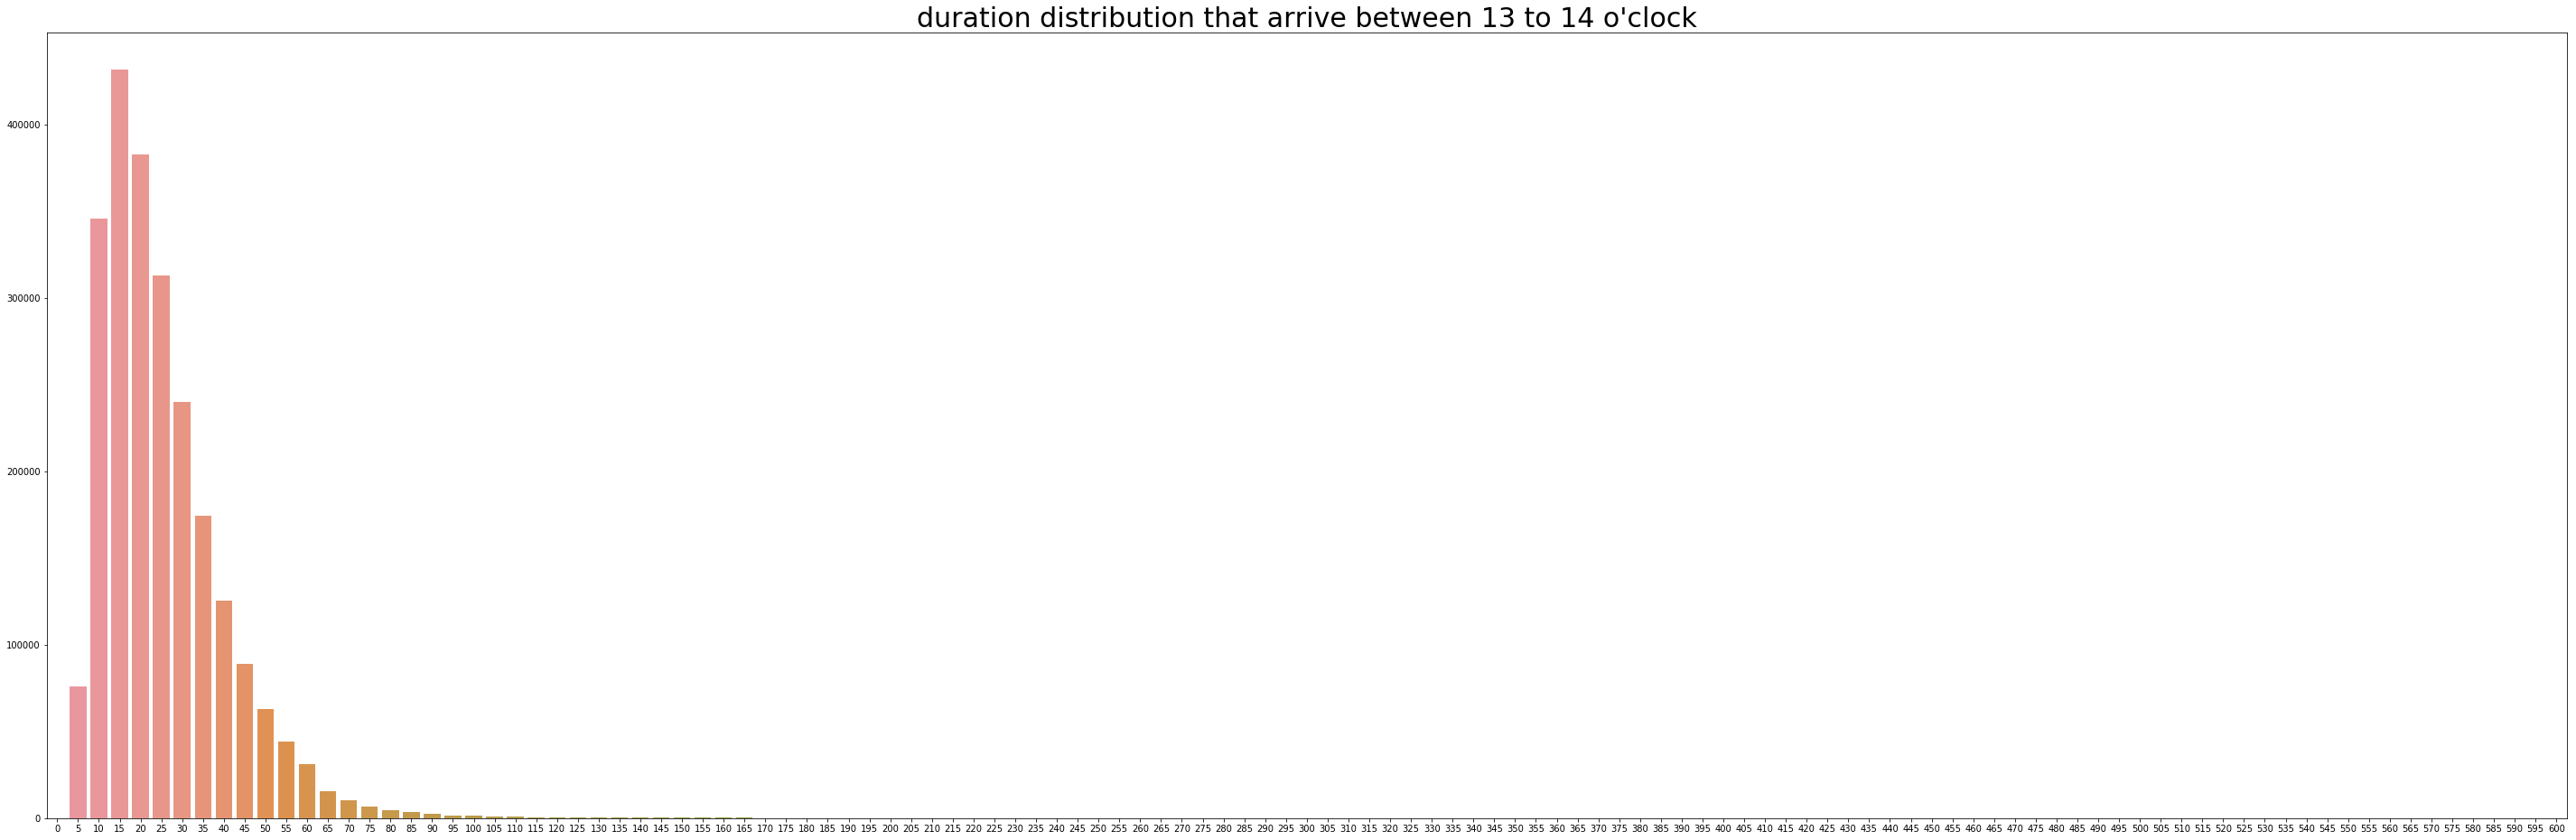

In [72]:
fig = plt.figure(5,figsize = (50,16))
ax = sns.barplot(x, y)
plt.title('duration distribution that arrive between 13 to 14 o\'clock', fontsize= 30)
plt.show()                                                              #plot the time duration of trips taken between 1pm to 2pm

## Fit normal distribution with training set

In [16]:
msk = np.random.rand(len(data2)) < 0.8 #Splitting the data into training and test data.
train = data2[msk]
test = data2[~msk]

In [128]:
test.shape[0]                   #testing data size

472773

In [17]:
x1 = [i for i in range(5,601,5)]
y1 = []
for i in range(1,len(x)):                                 #Calculating number of trips in the time interval of 5min 
    y1.append(train.loc[(train['trip_duration'].dt.total_seconds()/60 > x[i-1]) &
                      (train['trip_duration'].dt.total_seconds()/60 <= x[i])].shape[0])

In [21]:
from scipy.stats import norm                             #importing norm funcion to calculate the normal distribution

In [22]:
sample = train['trip_duration'].dt.total_seconds()/60

In [23]:
mu,sigma = norm.fit(sample)                              #fitting the training data for normal distribution

In [24]:
mu,sigma    #Getting mean trip duration and standard deviation of the distribution

(22.824029195090521, 15.943166758904487)

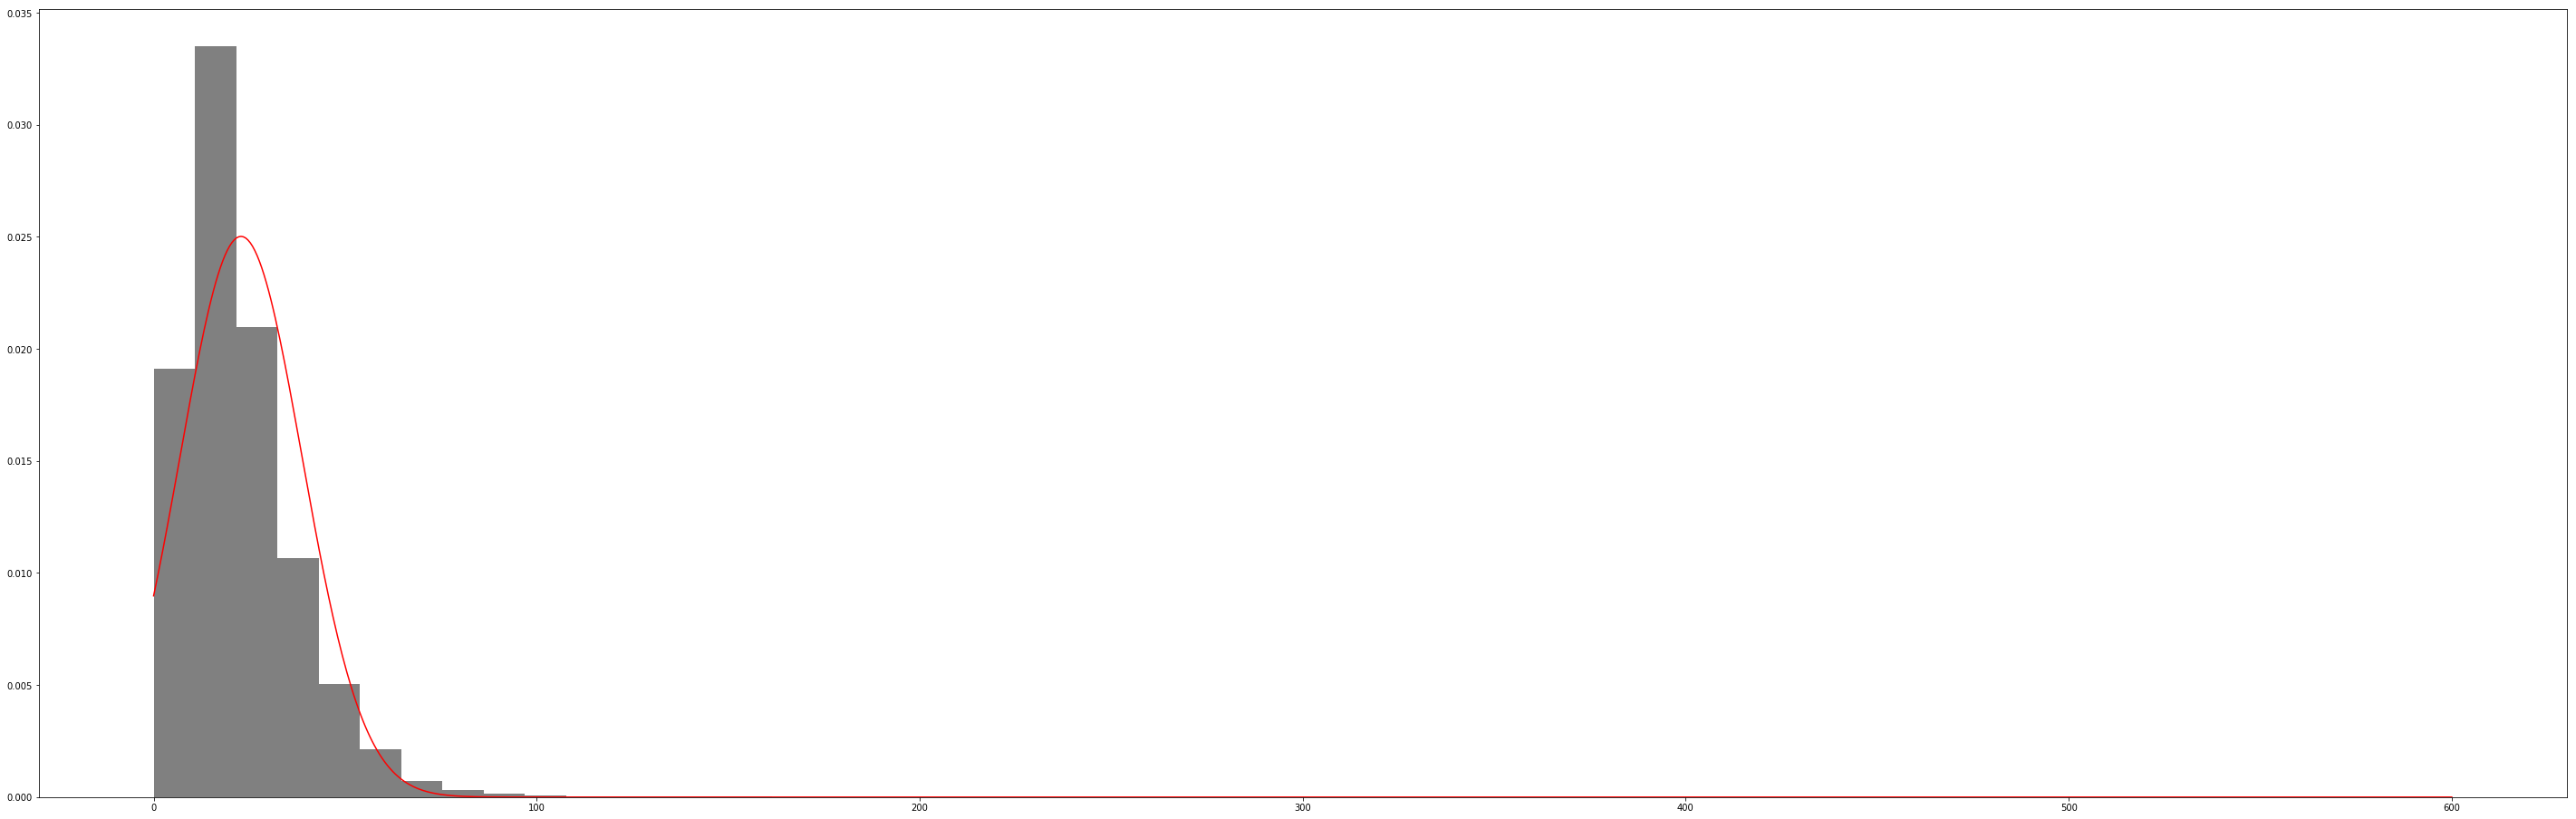

In [81]:
from pylab import plot,show,hist,figure,tile
fig = plt.figure(5,figsize = (50,16))                            #Plotting the histogram of the test data
sample2 = test['trip_duration'].dt.total_seconds()/60
x_axis = np.linspace(0,600,1000)
pdf_fitted = norm.pdf(x_axis,loc = mu,scale = sigma)
plot(x_axis,pdf_fitted,'r-')
hist(sample2,35,normed = True,facecolor='gray')
show()

## Analyze the fitting

In [82]:
a = sample2.groupby(sample2).size()

In [89]:
y = a/sample2.shape[0]

In [93]:
y = y.values                                           # actual value of test data set

In [95]:
y_hat = norm.pdf(a.index,loc = mu, scale = sigma)      #predicted value for test set

In [104]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [106]:
MSE = mean_squared_error(y,y_hat)                      #Calculating the Mean Square Error
MSE

0.00014560332346594864

## Start Time Estimation

In [116]:
minu = pd.to_timedelta(mu, unit='m')
t = pd.to_datetime('14:00:00',format = '%H:%M:%S')

In [125]:
str((t-minu).time())                         # start time for reaching at 2pm

'13:37:10.558260'